In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from tqdm import tqdm

import tweeterator
from loader import Loader
from data_generator import DataGenerator

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


GPU found


# Setup

Setup training parameters

In [2]:
input = 'data/trump.csv'
text_column = 'text'
file_type = 'csv'
net_type = 'LSTM'
latent_dim = 64
n_units = 256
window = 5
dropout = 0.2
batch_size = 64
epochs = 30
learning_rate = 0.001
perc_val = 0.2
n_hidden_layers = 1
regex_to_remove = ['^rt ']
shuffle = True

Initialise loader

In [3]:
loader = Loader(flatten_hashtags=False, flatten_mentions=False)
data = loader.load(input, file_type=file_type, text_column=text_column, window=window, regex_to_remove=regex_to_remove)
data = np.array(data, dtype=object)

# Inspect

Look at loaded sentences

In [4]:
# Number of unique words
print(f"Number of words: {len(list(itertools.chain(*data)))}")
print(f"Number of unique words: {len(set(itertools.chain(*data)))}")

Number of words: 1020852
Number of unique words: 61684


Remove words that appear only once (probably typos, errors, etc.)

In [5]:
flattened_text = list(itertools.chain(*data))
vc = pd.value_counts(flattened_text)
words_to_remove = vc[vc == 1].index

In [6]:
words_to_remove

Index(['nh1', '@judicialwatc..', 'httpt.colldabpilaq', ''stars'',
       'httpst.cowpjim8n7m2', '@bobzilla305', 'lady..', '@discjocke52',
       'commun..', '@dusty_radio',
       ...
       '@tftamt', '37.', 'downlost', 'waysad', '@bollingsballs', 'welltough',
       '@classiced', '@bomoca', '@aboubacarmande', 'httpst.conwsz5tgz5e'],
      dtype='object', length=40454)

In [7]:
counts = []
for sentence in data:
    count = 0
    for word in list(sentence):
        if word in words_to_remove:
            sentence.remove(word)
            count += 1
    
    counts.append(count)

In [8]:
print(f'Number of affected sentences: {np.sum(np.array(counts) > 0)}')

Number of affected sentences: 28922


In [9]:
print(f"Total number of sentences: {len(counts)}")

Total number of sentences: 70524


In [10]:
empty_sentences = []
for i in range(len(data)):
    sentence = data[i]
    if len(sentence) == 0:
        empty_sentences.append(i)

data = np.delete(data, empty_sentences)

In [11]:
for sentence in data[:5]:
    print('-' + ' '.join(sentence))

-republicans and democrats have both created our economic problems
-i was thrilled to be back in the great city of charlotte north carolina with thousands of hardworking american patriots who love our country cherish our values respect our laws and always put america first thank you for a wonderful evening #kag2020
-@cbs_herridge read letter to surveillance court obtained by cbs news questions where there will be further disciplinary action and
-the unsolicited mail in ballot scam is a major threat to our democracy amp the democrats know it
-almost all recent elections using this system even though much smaller amp with far fewer ballots to count have ended up being a disaster


POS tagging

In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
# Get frequencies of part-of-speech (POS) tags. These will be taken into consideration when choosing the next word to generate
dict_pos_freq = {}
dict_pos_count = {}

for sentence in tqdm(data):
    words_and_pos_tags = nltk.pos_tag(sentence)
    pos_tags = list(zip(*words_and_pos_tags))[1]
    for i in range(len(sentence) - window):
        preceding = str(pos_tags[i:i+window])
        following = pos_tags[i+window]
        try:
            dict_pos_count[preceding] += 1
            try:
                # Increase the frequency of seeing the window preceding POSs and then the following POS
                dict_pos_freq[preceding][following] += 1
            except KeyError:
                dict_pos_freq[preceding][following] = 1
        except KeyError:
            dict_pos_freq[preceding] = {following: 1}
            dict_pos_count[preceding] = 1

# Normalise each count to obtain a frequency
for k1 in dict_pos_freq.keys():
    v1 = dict_pos_freq[k1]
    count = dict_pos_count[k1]
    for k2 in v1.keys():
        v1[k2] = v1[k2] / count

100%|██████████| 70520/70520 [01:43<00:00, 679.12it/s]


In [16]:
min_freq = 1
for k1 in dict_pos_freq.keys():
    v1 = dict_pos_freq[k1]
    for k2 in v1.keys():
        if v1[k2] < min_freq:
            min_freq = v1[k2]

# Train

Train and get the trained model, the history and the word dictionaries

In [15]:
model, history, dicts, _ = tweeterator.train(data, net_type, latent_dim, n_units, window, dropout, batch_size, epochs, learning_rate,
                                             perc_val, n_hidden_layers, shuffle)

Epoch 1/30
882/882 [==============================] - 39s 38ms/step - loss: 7.3883 - categorical_accuracy: 0.0461 - val_loss: 7.1579 - val_categorical_accuracy: 0.0459
Epoch 2/30
882/882 [==============================] - 31s 35ms/step - loss: 7.0091 - categorical_accuracy: 0.0595 - val_loss: 6.9306 - val_categorical_accuracy: 0.0672
Epoch 3/30
882/882 [==============================] - 31s 35ms/step - loss: 6.7676 - categorical_accuracy: 0.0766 - val_loss: 6.6684 - val_categorical_accuracy: 0.0864
Epoch 4/30
882/882 [==============================] - 31s 35ms/step - loss: 6.5708 - categorical_accuracy: 0.0888 - val_loss: 6.5250 - val_categorical_accuracy: 0.0972
Epoch 5/30
882/882 [==============================] - 31s 36ms/step - loss: 6.4015 - categorical_accuracy: 0.1026 - val_loss: 6.3821 - val_categorical_accuracy: 0.1092
Epoch 6/30
882/882 [==============================] - 32s 36ms/step - loss: 6.3035 - categorical_accuracy: 0.1097 - val_loss: 6.3352 - val_categorical_accuracy:

Visualise training results

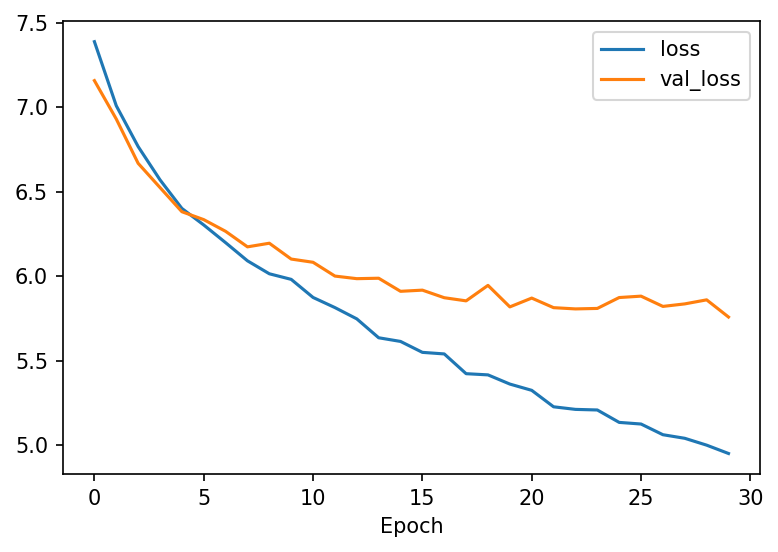

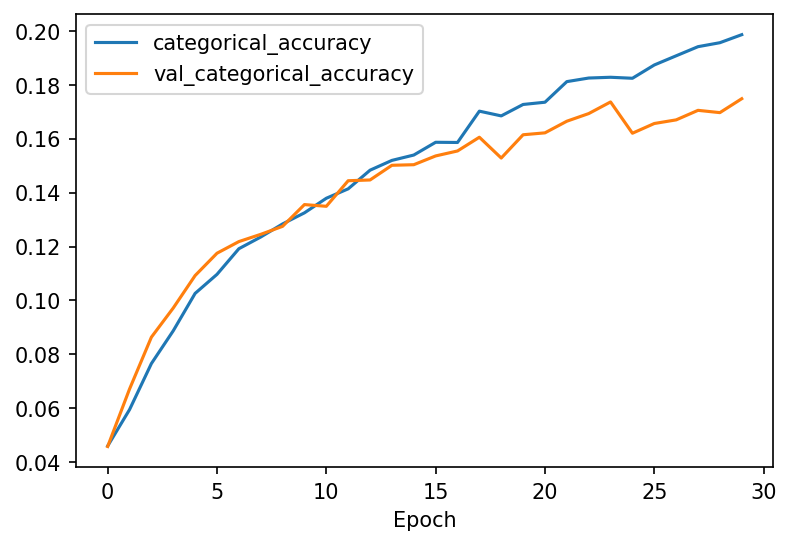

In [18]:
plt.figure(dpi=150)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.figure(dpi=150)
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.xlabel('Epoch')
plt.legend()

# Test

Take a random sentence and start generating text from its first words

In [19]:
w2i = dicts['word2int']
i2w = dicts['int2word']

In [20]:
sentence = data[np.random.choice(data.size, 1)]
gen = DataGenerator(sentence, w2i, window, 1, shuffle=False)
test_example = next(gen)

In [45]:
deterministic = False
use_pos_info = True

In [48]:
output_size = 40
output_int = np.empty(output_size, dtype=int)

# Set the first window elements to the start of the phrase
output_int[:window] = test_example[0]

# Predict the next word from the preceding ones (using the words already predicted)
for i in range(0, output_int.size - window):
    input_int = output_int[np.newaxis, i:window+i, np.newaxis]
    prediction = model(input_int).numpy()[0]
    
    if use_pos_info:
        input_str = [i2w[ii] for ii in output_int[i:window+i]]
        words_and_pos_tags = nltk.pos_tag(input_str)
        pos_tags = list(zip(*words_and_pos_tags))[1]
        preceding = str(pos_tags)
        try:
            pos_freqs = dict_pos_freq[preceding]
        except KeyError:
            pos_freqs = None
        
        best_guesses = np.argsort(prediction)[::-1][:10]
        posterior = []
        for guess in best_guesses:
            # Get the POS tag for the examined word
            test_str = input_str + [i2w[guess]]

            guess_pos = nltk.pos_tag(test_str)[-1][1]
            try:
                pos_prob = pos_freqs[guess_pos]
            except KeyError:
                # If this sequence was never observed give it a probability equal to the minimum frequence observed
                pos_prob = min_freq
            except TypeError:
                # if pos_freqs is None because the sequence was not found in the trining data, do not vary the
                # predictions
                pos_prob = 1

            prior = prediction[guess]

            posterior.append(prior * pos_prob)
    
        if deterministic:
            chosen_guess = np.argmax(posterior)
        else:
            posterior = np.array(posterior) / np.sum(posterior)
            chosen_guess = np.random.choice(range(len(posterior)), 1, p=posterior)[0]
        
        word_int = best_guesses[chosen_guess]
    else:
        if deterministic:
            word_int = np.argmax(prediction)
        else:
            word_int = np.random.choice(range(len(prediction)), 1, p=prediction)[0]

    output_int[window + i] = word_int

# Convert integers to words
output = []
for i in range(len(output_int)):
    word_int = output_int[i]
    word = i2w[word_int]
    output.append(word)

Visualise the produced output

In [49]:
' '.join(output)

'republicans at hearing find no polling mandarin spoken than any other country in the world amp i have been asking to be president obama will have a great governor of virginia with north carolina in south carolina was great httpst.cobefd1v77nf'